# 略語の傾向を分析してみる

In [27]:
from type import Abbreviation, Mora, Syllable
import json
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import numpy as np

In [28]:
# 前処理した略語データを読み込む
data = list(map(Abbreviation.model_validate, json.load(open("./data/abbreviation.json", "r"))))

In [29]:
# データサイズ
len(data)

1267

原語と略語の要素数を比較してみる

対象は原語の要素数が2以上のもの
原語→略語で要素数が同じものと減るものがあるはず

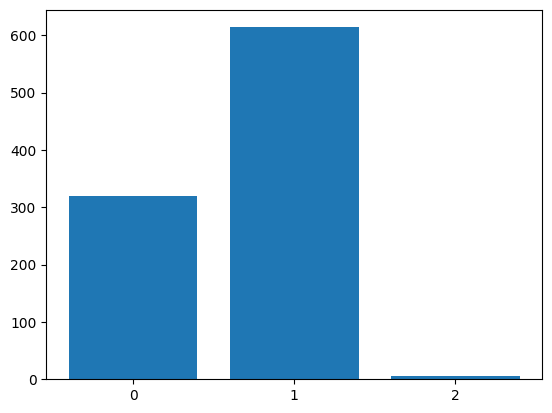

In [30]:
elem_count_by_diff: defaultdict[str, int] = defaultdict(int)
for abb in data:
    if len(abb.word_element_list) < 2:
        continue
    elem_count_by_diff[str(len(abb.word_element_list) - len(abb.abbreviation_element_list))] += 1

elem_count_by_diff = dict(sorted(elem_count_by_diff.items(), key=lambda x: x[0]))
plt.bar(elem_count_by_diff.keys(), elem_count_by_diff.values())
plt.show()

いくつからいくつになったのかを調べてもいいかなと思った

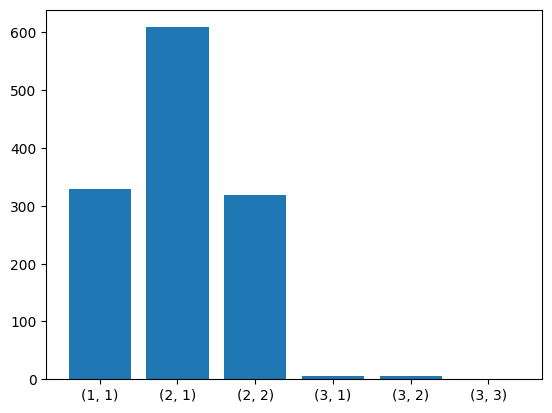

In [31]:
elem_count_by_diff: defaultdict[tuple[int, int], int] = defaultdict(int)
for abb in data:
    elem_count_by_diff[(len(abb.word_element_list), len(abb.abbreviation_element_list))] += 1

elem_count_by_diff = dict(sorted(elem_count_by_diff.items(), key=lambda x: x[0]))
plt.bar(list(map(str, elem_count_by_diff.keys())), elem_count_by_diff.values())
plt.show()

まず、原語が2要素の略語が多いことがわかった  
そのなかでも約2/3が要素数が1になっている

原語の要素数が1の略語も多く、個数は2要素のものの1/3である

原語の要素数が3のものは総数が少ないので、今回の分析ではあまり考えない

略されたあとの単語のモーラ数

[(2, 195), (3, 371), (4, 511), (5, 121), (6, 45), (7, 16), (8, 7), (9, 1)]


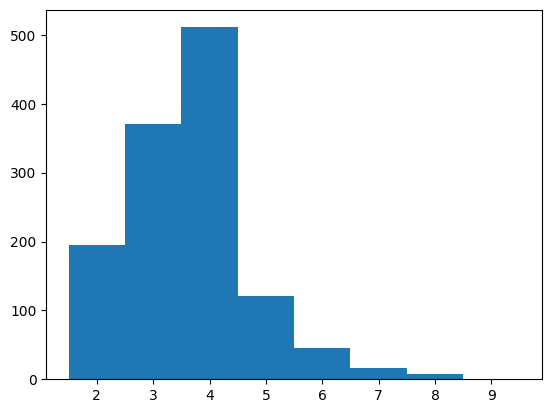

In [32]:
mora_cnt: list[int] = []
for abb in data:
    cnt = 0
    for elem in abb.abbreviation_element_list:
        cnt += len(elem.mora_list)
    mora_cnt.append(cnt)

counter = Counter(mora_cnt)
print(sorted(counter.items()))
plt.bar(counter.keys(), counter.values(), width=1)
plt.show()

原語のモーラ数と略語のモーラ数を比べてみる

[[  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   1   0   0]
 [  0   0   0   0   3   0   1   0   0   0]
 [  0   0   0   1   5   0   0   0   0   0]
 [  0   0   0   2  15   4   1   3   0   1]
 [  0   0   1   4  27   8   7   4   7   0]
 [  0   0   1  12  38  14   9   7   0   0]
 [  0   0   4  12  81  27  25   1   0   0]
 [  0   0  11  42  99  56   2   0   0   0]
 [  0   0  13  83 157  11   0   0   0   0]
 [  0   0  53 159  73   1   0   0   0   0]
 [  0   0  67  48  11   0   0   0   0   0]
 [  0   0  38   8   0   0   0   0   0   0]
 [  0   0   7   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


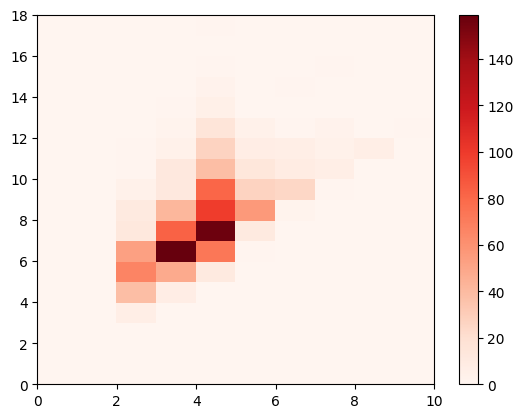

In [33]:
mora_cnt: defaultdict[tuple[int, int], int] = defaultdict(int)
a_cnt_max = 0
w_cnt_max = 0

for abb in data:
    a_cnt = 0
    for elem in abb.abbreviation_element_list:
        a_cnt += len(elem.mora_list)
    w_cnt = 0
    for elem in abb.word_element_list:
        w_cnt += len(elem.mora_list)
    mora_cnt[(w_cnt, a_cnt)] += 1
    a_cnt_max = max(a_cnt_max, a_cnt)
    w_cnt_max = max(w_cnt_max, w_cnt)

cnt = np.array([[0] * (a_cnt_max + 1) for _ in range(w_cnt_max + 1)], dtype=int)
for w in range(w_cnt_max + 1):
    for a in range(a_cnt_max + 1):
        cnt[w][a] = mora_cnt[(w, a)]
print(cnt[::-1])
fig, ax = plt.subplots()
mappable = ax.pcolor(cnt, cmap="Reds")
plt.colorbar(mappable)
plt.show()

当然ながら、原語のモーラ数と略語のモーラ数には正の相関があった

原語→略語のモーラ数の平均減少率

/var/folders/4x/vf52k2q52wx0sqrm0t5hfr040000gn/T/ipykernel_3354/2985987010.py:11: RuntimeWarning: Mean of empty slice.
  means = [np.array(li).mean() / (i + 1) for i, li in enumerate(diffs[1:])]


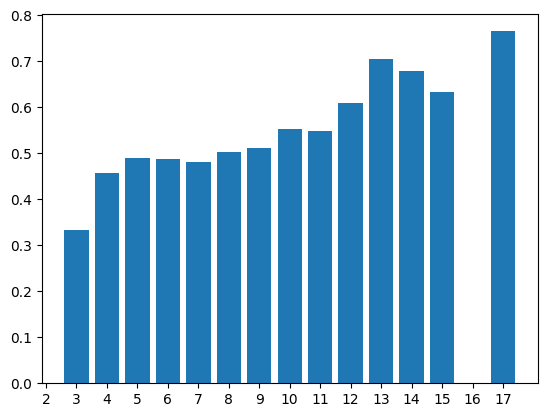

In [34]:
diffs = [[] for _ in range(w_cnt_max + 1)]
for abb in data:
    a_cnt = 0
    for elem in abb.abbreviation_element_list:
        a_cnt += len(elem.mora_list)
    w_cnt = 0
    for elem in abb.word_element_list:
        w_cnt += len(elem.mora_list)
    diffs[w_cnt].append(w_cnt - a_cnt)

means = [np.array(li).mean() / (i + 1) for i, li in enumerate(diffs[1:])]
plt.bar(list(map(str, range(1, w_cnt_max + 1))), means)
plt.show()

当たり前だけど原語のモーラ数が多いほど省略率が高くなっている

モーラの頻度解析

In [35]:
abb_mora_cnt: defaultdict[Mora, int] = defaultdict(int)
word_mora_cnt: defaultdict[Mora, int] = defaultdict(int)
for abb in data:
    for elem in abb.abbreviation_element_list:
        for mora in elem.mora_list:
            abb_mora_cnt[mora] += 1
    for elem in abb.word_element_list:
        for mora in elem.mora_list:
            word_mora_cnt[mora] += 1

mora_cnt_diff: defaultdict[Mora, int] = defaultdict(int)
for mora in word_mora_cnt.keys():
    mora_cnt_diff[mora] = (word_mora_cnt[mora] - abb_mora_cnt[mora]) / word_mora_cnt[mora]

sorted_mora_cnt_diff = sorted(mora_cnt_diff.items(), key=lambda x: -x[1])
for diff in sorted_mora_cnt_diff:
    mora, ratio = diff
    if word_mora_cnt[mora] > 20:
        print(diff)

(('sh', 'o'), 0.8627450980392157)
(('th', 'i'), 0.8307692307692308)
(('z', 'u'), 0.8076923076923077)
(('m', 'u'), 0.801980198019802)
(('f', 'i'), 0.7666666666666667)
(('ts', 'u'), 0.6829268292682927)
(('', 'e'), 0.6634304207119741)
(('', 'u'), 0.632258064516129)
(('g', 'u'), 0.625)
(('Q', ''), 0.6197604790419161)
(('dh', 'i'), 0.6)
(('t', 'o'), 0.5995575221238938)
(('j', 'i'), 0.5957446808510638)
(('t', 'a'), 0.593939393939394)
(('n', 'a'), 0.5517241379310345)
(('r', 'u'), 0.5507246376811594)
(('', 'a'), 0.5489864864864865)
(('k', 'u'), 0.5460750853242321)
(('d', 'a'), 0.5454545454545454)
(('', 'i'), 0.5432692307692307)
(('N', ''), 0.5384615384615384)
(('s', 'u'), 0.5357142857142857)
(('d', 'o'), 0.5284090909090909)
(('m', 'e'), 0.5225225225225225)
(('sh', 'u'), 0.5217391304347826)
(('r', 'e'), 0.521551724137931)
(('', 'o'), 0.5172413793103449)
(('j', 'a'), 0.5172413793103449)
(('n', 'i'), 0.5142857142857142)
(('t', 'e'), 0.5040650406504065)
(('k', 'i'), 0.48484848484848486)
(('b', 'o'

`mo`, `po`, `mi`が省略されにくいのは両唇音だからかしら？  
赤ちゃんがパパ、ママというのは言いやすいからとよく言われるが、これにもその傾向があればおもしろい

[両唇音](https://ja.wikipedia.org/wiki/%E4%B8%A1%E5%94%87%E9%9F%B3)

子音ごとに省略率の傾向を見てみようかな？

In [36]:
# 子音ごとに省略率を比較
a_mora_cnt_by_cons: defaultdict[str, int] = defaultdict(int)
w_mora_cnt_by_cons: defaultdict[str, int] = defaultdict(int)
for mora in word_mora_cnt.keys():
    w_mora_cnt_by_cons[mora.consonant] += word_mora_cnt[mora]
    a_mora_cnt_by_cons[mora.consonant] += abb_mora_cnt[mora]
diff_by_cons: defaultdict[str, float] = defaultdict(float)
for cons in w_mora_cnt_by_cons.keys():
    diff_by_cons[cons] = (w_mora_cnt_by_cons[cons] - a_mora_cnt_by_cons[cons]) / w_mora_cnt_by_cons[cons]

sorted_diff_by_cons = sorted(diff_by_cons.items(), key=lambda x: -x[1])
for diff in sorted_diff_by_cons:
    cons, ratio = diff
    if w_mora_cnt_by_cons[cons] > 10:
        print(diff)

('py', 0.9285714285714286)
('my', 0.8421052631578947)
('th', 0.8307692307692308)
('ts', 0.6829268292682927)
('z', 0.6707317073170732)
('sh', 0.6588785046728972)
('Q', 0.6197604790419161)
('dh', 0.6)
('j', 0.5855263157894737)
('t', 0.5824324324324325)
('', 0.5689558905639308)
('v', 0.5555555555555556)
('N', 0.5384615384615384)
('g', 0.5370370370370371)
('s', 0.5023847376788553)
('d', 0.4861111111111111)
('r', 0.45417680454176806)
('m', 0.45083932853717024)
('n', 0.44)
('ch', 0.4387755102040816)
('k', 0.4322396576319544)
('b', 0.4263803680981595)
('f', 0.40588235294117647)
('p', 0.363013698630137)
('h', 0.35384615384615387)
('w', 0.35294117647058826)
('y', 0.3488372093023256)
('ky', 0.21739130434782608)


In [37]:
# 母音でもやってみる
a_mora_cnt_by_vowel: defaultdict[str, int] = defaultdict(int)
w_mora_cnt_by_vowel: defaultdict[str, int] = defaultdict(int)
for mora in word_mora_cnt.keys():
    w_mora_cnt_by_vowel[mora.vowel] += word_mora_cnt[mora]
    a_mora_cnt_by_vowel[mora.vowel] += abb_mora_cnt[mora]
diff_by_vowel: defaultdict[str, float] = defaultdict(float)
for vowel in w_mora_cnt_by_vowel.keys():
    diff_by_vowel[vowel] = (w_mora_cnt_by_vowel[vowel] - a_mora_cnt_by_vowel[vowel]) / w_mora_cnt_by_vowel[vowel]

sorted_diff_by_vowel = sorted(diff_by_vowel.items(), key=lambda x: -x[1])
for diff in sorted_diff_by_vowel:
    vowel, ratio = diff
    if w_mora_cnt_by_vowel[vowel] > 10:
        print(diff)

('', 0.5622807017543859)
('u', 0.5519662921348315)
('e', 0.5175438596491229)
('i', 0.5084745762711864)
('o', 0.47619047619047616)
('a', 0.45553257497414684)


子音では省略率に差が出ることがわかった  
母音ではほとんど差が出ず、子音のみで省略率が変わることがわかった

仮説のような両唇音が省略されにくいということはなかった

文字の配置にも注目したい

まずは1要素の略語のみに着目する

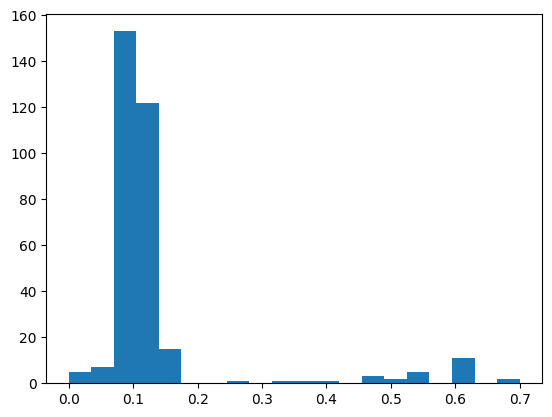

In [38]:
data_one_elem = [abb for abb in data if len(abb.word_element_list) == 1]
pos_sum = np.array([])

for abb in data_one_elem:
    w_length = len(abb.word_element_list[0].mora_list)
    a_length = len(abb.abbreviation_element_list[0].mora_list)
    cnt = 0.0
    cur = 0
    for i, mora in enumerate(abb.word_element_list[0].mora_list):
        if mora == abb.abbreviation_element_list[0].mora_list[cur]:
            cur += 1
            cnt += i
            if cur == a_length:
                break
    cnt -= (a_length - 1) * (a_length - 2) / 2  # 0からa_length-1までの和を差し引く
    cnt /= w_length  # 要素全体を1としたときの位置
    cnt /= a_length  # 略語の長さで割って平均を取る
    pos_sum = np.append(pos_sum, cnt)

plt.hist(pos_sum, bins=20)
plt.show()

In [39]:
data_one_elem = np.array(data_one_elem)

# 後ろが残った単語を表示
print(*data_one_elem[pos_sum >= 0.2], sep="\n")

Abbreviation(ブランケット -> ケット)
Abbreviation(コスメチック -> チック)
Abbreviation(アルミニューム -> ニューム)
Abbreviation(ワニス -> ニス)
Abbreviation(フランネル -> ネル)
Abbreviation(タイピスト -> ピスト)
Abbreviation(コンミッション -> ミッション)
Abbreviation(モルヒネ -> モヒ)
Abbreviation(ウイスキー -> イスキー)
Abbreviation(ウオーク -> オーク)
Abbreviation(マニユスクリプト -> スクリプト)
Abbreviation(ネクタイ -> タイ)
Abbreviation(ウルトラ -> トラ)
Abbreviation(ボーナス -> ナス)
Abbreviation(スパイ -> パイ)
Abbreviation(テレフォーン -> フォーン)
Abbreviation(ジステンパー -> テンパー)
Abbreviation(アルバイト -> バイト)
Abbreviation(キャラバン -> バン)
Abbreviation(アドバンス -> バンス)
Abbreviation(ヒロポン -> ポン)
Abbreviation(ダイナマイト -> マイト)
Abbreviation(パントマイム -> マイム)
Abbreviation(ヘルメット -> メット)
Abbreviation(インターネット -> ネット)
Abbreviation(トランペット -> ペット)
Abbreviation(メンソレータム -> メンタム)


1要素の単語では先頭部分が残り、後ろが省略されることが多い
前後から均等に取るような略し方はあまりない